
# Neural Network and Fuzzy Logic Control — Lab Notebook

**Aligned to MAKAUT (WBUT) PE-EC702C syllabus**  
*Generated by Shinjan Saha*

This notebook is structured as a practical companion to the syllabus. Each topic includes:
- A concise concept recap
- Python implementation (from-scratch where feasible)
- Visualizations / outputs
- A short note on *why this matters* for the course outcomes

> Dependencies: only `numpy` and `matplotlib` are used to keep things portable.


In [2]:

# === Common Imports and Helpers ===
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
rng = np.random.default_rng(42)

def plot_decision_boundary_2d(predict_fn, X, y, title="Decision Boundary"):
    # Visualizes a binary classifier's decision regions for 2D inputs.
    # predict_fn: function that maps X -> {0,1}
    # X: (n,2), y: (n,)
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([predict_fn(pt) for pt in grid]).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k')
    plt.title(title)
    plt.show()

def one_hot(y, K=None):
    if K is None: K = np.max(y)+1
    oh = np.zeros((y.size, K))
    oh[np.arange(y.size), y] = 1
    return oh



## 1. Neural Networks and Pattern Association

Syllabus coverage: *McCulloch–Pitts neuron, Perceptron, Adaline, Madaline; Hebb rule, Delta rule; Hetero/Auto/Iterative Auto-associative; BAM.*



### 1.1 McCulloch–Pitts Neuron (Linear Threshold Unit)

**Why it matters:** Forms the conceptual foundation of all artificial neurons. Demonstrates linear thresholding and boolean function modeling.


In [3]:

def mcp_neuron(x, w, theta):
    s = np.dot(x, w)
    return 1 if s >= theta else 0

# Example: OR gate
w = np.array([1.0, 1.0])
theta = 1.0
tests = np.array([[0,0],[0,1],[1,0],[1,1]])
for t in tests:
    print(t, "->", mcp_neuron(t, w, theta))


[0 0] -> 0
[0 1] -> 1
[1 0] -> 1
[1 1] -> 1



### 1.2 Perceptron (Rosenblatt) — Learning Rule & Linear Separability

**Why it matters:** First supervised learning algorithm for classification; connects to linear separability in the syllabus.


Weights: [0.4 0.2] Bias: -0.4000000000000001
[0 0] -> 0 (true: 0 )
[0 1] -> 0 (true: 0 )
[1 0] -> 0 (true: 0 )
[1 1] -> 1 (true: 1 )


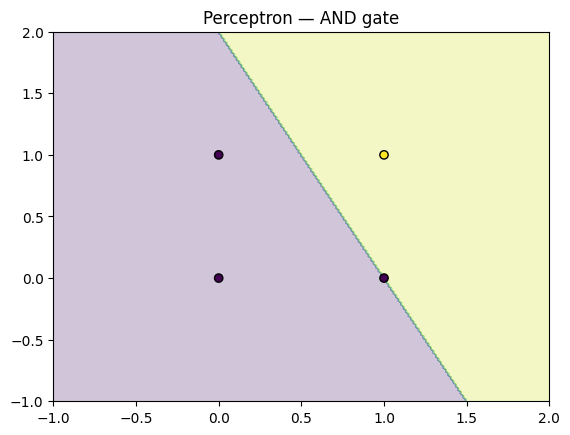

In [4]:

def perceptron_train(X, y, lr=0.1, epochs=20):
    w = np.zeros(X.shape[1])
    b = 0.0
    for _ in range(epochs):
        for i in range(len(X)):
            yhat = 1 if (np.dot(X[i], w) + b) >= 0 else 0
            e = y[i] - yhat
            w += lr * e * X[i]
            b += lr * e
    return w, b

def perceptron_predict(x, w, b):
    return 1 if (np.dot(x, w) + b) >= 0 else 0

# AND gate training
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,0,0,1])
w, b = perceptron_train(X, y, lr=0.2, epochs=15)

print("Weights:", w, "Bias:", b)
for xi, yi in zip(X, y):
    print(xi, "->", perceptron_predict(xi, w, b), "(true:", yi, ")")

plot_decision_boundary_2d(lambda pt: perceptron_predict(pt, w, b), X, y, "Perceptron — AND gate")



### 1.3 Adaline & Madaline (Adaptive Linear Neuron/Elements)

**Why it matters:** Introduces least-mean-square (LMS) learning and shows difference between hard limit (Perceptron) vs linear activation trained by gradient descent.


In [ ]:

def adaline_train(X, y, lr=0.1, epochs=50):
    w = rng.normal(scale=0.1, size=X.shape[1])
    b = 0.0
    for _ in range(epochs):
        yhat = X @ w + b
        e = y - yhat
        w += lr * X.T @ e / len(X)
        b += lr * np.sum(e) / len(X)
    return w, b

def adaline_predict(x, w, b):
    return 1 if (np.dot(x, w) + b) >= 0 else 0

# Train on OR gate with targets as {0,1} and linear model + threshold at 0
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([0,1,1,1]).astype(float)
w, b = adaline_train(X, y, lr=0.2, epochs=40)
print("Adaline w,b:", w, b)
for xi, yi in zip(X, y):
    print(xi, "->", adaline_predict(xi, w, b), "(true:", int(yi), ")")

# Madaline: simple 2-hidden linear units + linear output
def madaline_predict(x, W_hidden, b_hidden, w_out, b_out):
    h = x @ W_hidden + b_hidden  # linear hidden
    o = np.dot(h, w_out) + b_out
    return 1 if o >= 0 else 0

# Build a tiny Madaline with two hidden units for OR
W_hidden = np.array([[1.0, 1.0], [1.0, 1.0]]) * 0.5
b_hidden = np.array([-0.25, -0.75])
w_out = np.array([1.0, 1.0])
b_out = -0.1
for xi, yi in zip(X, y.astype(int)):
    print("Madaline:", xi, "->", madaline_predict(xi, W_hidden, b_hidden, w_out, b_out), "(true:", yi, ")")



### 1.4 Hebb Rule & Delta (Widrow–Hoff) Rule

**Why it matters:** Fundamental learning rules for associative learning (Hebb) and LMS optimization (Delta). Shows unsupervised vs supervised perspectives.


In [ ]:

# Hebbian learning for hetero-associative mapping X -> y (binary inputs/targets)
def hebb_train(X, Y):
    # X: (n,d), Y: (n,k) targets in {-1,1}
    # W: (d,k)
    W = np.zeros((X.shape[1], Y.shape[1]))
    for i in range(len(X)):
        W += np.outer(X[i], Y[i])
    return W

# Delta rule (LMS) for linear model
def delta_rule_train(X, Y, lr=0.1, epochs=200):
    W = rng.normal(scale=0.1, size=(X.shape[1], Y.shape[1]))
    b = np.zeros((1, Y.shape[1]))
    for _ in range(epochs):
        Yhat = X @ W + b
        E = Y - Yhat
        W += lr * X.T @ E / len(X)
        b += lr * np.mean(E, axis=0, keepdims=True)
    return W, b

# Example mapping: 2D -> 2D (hetero-associative), targets in {-1,1}
X = np.array([[1,1],[1,-1],[-1,1],[-1,-1]])
Y = np.array([[1,1],[1,-1],[-1,1],[-1,-1]])
W_hebb = hebb_train(X, Y)
print("Hebb W:\n", W_hebb)

W_delta, b_delta = delta_rule_train(X.astype(float), Y.astype(float), lr=0.2, epochs=300)
print("Delta W:\n", W_delta, "\nDelta b:\n", b_delta)



### 1.5 Associative Memories — Hetero/Auto & Iterative Auto-Associative

**Why it matters:** Associates patterns with outputs (hetero-association) or with themselves (auto-association), connecting directly to “pattern association” in the syllabus.


In [ ]:

def sign(x): return np.where(x>=0, 1, -1)

# Hetero-associative recall with Hebbian weights
def hetero_recall(x, W):
    y = x @ W
    return sign(y)

# Auto-associative (Hopfield-style) with Hebbian outer products
def hopfield_train(patterns):
    n = patterns.shape[1]
    W = np.zeros((n,n))
    for p in patterns:
        W += np.outer(p, p)
    np.fill_diagonal(W, 0)
    return W / patterns.shape[0]

def hopfield_update_async(state, W, steps=10):
    s = state.copy()
    n = len(s)
    for _ in range(steps):
        i = rng.integers(0, n)
        s[i] = 1 if np.dot(W[i], s) >= 0 else -1
    return s

# Demo
P = np.array([[1,1,-1,-1],[1,-1,1,-1],[-1,1,1,-1]])  # stored patterns (auto)
W_hop = hopfield_train(P)

probe = np.array([1,1,-1,-1])  # clean
noisy = probe.copy()
flip_idx = rng.choice(len(noisy), 2, replace=False)
noisy[flip_idx] *= -1
print("Noisy probe:", noisy)
recovered = hopfield_update_async(noisy, W_hop, steps=1000)
print("Recovered:", recovered)



### 1.6 Bidirectional Associative Memory (BAM)

**Why it matters:** Models two-way associations (X↔Y) with iterative recall. Appears explicitly in the syllabus.


In [ ]:

def bam_train(X, Y):
    # X: (p, n), Y: (p, m), values in {-1,1}
    W = X.T @ Y
    return W

def bam_recall(x, W, steps=10):
    # Alternating updates x->y->x
    x_curr = x.copy()
    for _ in range(steps):
        y = sign(x_curr @ W)
        x_curr = sign(y @ W.T)
    return x_curr, y

# Demo
X = np.array([[1,1,-1],[-1,1,1]])
Y = np.array([[1,-1],[1,1]])
W = bam_train(X, Y)
x_probe = np.array([1,1,-1])
x_rec, y_rec = bam_recall(x_probe, W, steps=5)
print("Recall x:", x_rec, "y:", y_rec)



## 2. Neural Networks based on Competition

Syllabus coverage: *Kohonen Self-Organizing Maps (SOM), Learning Vector Quantization (LVQ), Counter Propagation Networks (CPN).*



### 2.1 Kohonen Self-Organizing Map (SOM)

**Why it matters:** Unsupervised topology-preserving mapping; appears explicitly under “competition” networks.


In [ ]:

def som_train(X, map_shape=(10,10), epochs=50, lr_start=0.5, sigma_start=3.0):
    """
    A minimal SOM on 2D inputs.
    """
    h, w = map_shape
    W = rng.normal(size=(h*w, X.shape[1]))
    coords = np.array([(i,j) for i in range(h) for j in range(w)])

    def neighborhood(bmu_idx, sigma):
        d2 = np.sum((coords - coords[bmu_idx])**2, axis=1)
        return np.exp(-d2/(2*sigma**2))

    for t in range(epochs):
        lr = lr_start * (1 - t/epochs)
        sigma = max(1e-2, sigma_start * (1 - t/epochs))
        for x in X:
            dists = np.linalg.norm(W - x, axis=1)
            bmu = np.argmin(dists)
            h_bmu = neighborhood(bmu, sigma)[:,None]  # (N,1)
            W += lr * h_bmu * (x - W)
    return W.reshape((h,w,-1))

# Demo on ring-shaped data
theta = np.linspace(0, 2*np.pi, 400)
X = np.c_[np.cos(theta), np.sin(theta)]
Wmap = som_train(X, map_shape=(8,8), epochs=60)
plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.5)
for i in range(Wmap.shape[0]):
    plt.plot(Wmap[i,:,0], Wmap[i,:,1], '-')
for j in range(Wmap.shape[1]):
    plt.plot(Wmap[:,j,0], Wmap[:,j,1], '-')
plt.title("SOM grid adapting to ring data")
plt.show()



### 2.2 Learning Vector Quantization (LVQ)

**Why it matters:** Supervised prototype-based classification derived from SOM concepts.


In [ ]:

def lvq_train(X, y, prototypes_per_class=1, lr=0.2, epochs=20):
    classes = np.unique(y)
    prototypes = []
    proto_labels = []
    # Init: sample prototypes from data of each class
    for c in classes:
        idx = np.where(y==c)[0]
        sel = rng.choice(idx, size=prototypes_per_class, replace=False)
        for s in sel:
            prototypes.append(X[s].copy())
            proto_labels.append(c)
    prototypes = np.array(prototypes)
    proto_labels = np.array(proto_labels)

    for _ in range(epochs):
        for i in rng.permutation(len(X)):
            x, label = X[i], y[i]
            dists = np.linalg.norm(prototypes - x, axis=1)
            j = np.argmin(dists)
            if proto_labels[j] == label:
                prototypes[j] += lr * (x - prototypes[j])
            else:
                prototypes[j] -= lr * (x - prototypes[j])
    return prototypes, proto_labels

# Demo: two Gaussian blobs
n = 120
X0 = rng.normal(loc=[-1,0], scale=0.4, size=(n,2))
X1 = rng.normal(loc=[1,0],  scale=0.4, size=(n,2))
X = np.vstack([X0, X1])
y = np.array([0]*n + [1]*n)
protos, plabels = lvq_train(X, y, prototypes_per_class=2, lr=0.15, epochs=25)

def lvq_predict(pt):
    d = np.linalg.norm(protos - pt, axis=1)
    return plabels[np.argmin(d)]

plot_decision_boundary_2d(lvq_predict, X, y, "LVQ Decision Regions")
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.4, edgecolor='k')
plt.scatter(protos[:,0], protos[:,1], c=plabels, marker='X', s=150)
plt.title("LVQ prototypes")
plt.show()



### 2.3 Counter Propagation Network (CPN)

**Why it matters:** Combines competitive (Kohonen) layer with supervised (Grossberg) layer for fast mapping.


In [ ]:

def cpn_train(X, Y, k=6, epochs=30, lr_k=0.3, lr_g=0.2):
    # X: inputs (n,d), Y: targets (n,m)
    n, d = X.shape
    m = Y.shape[1]
    W_k = rng.normal(size=(k, d))  # Kohonen layer prototypes
    W_g = rng.normal(size=(k, m))  # Grossberg layer weights

    for _ in range(epochs):
        for i in rng.permutation(n):
            x, y = X[i], Y[i]
            # Winner-takes-all
            j = np.argmin(np.linalg.norm(W_k - x, axis=1))
            # Kohonen update
            W_k[j] += lr_k * (x - W_k[j])
            # Grossberg update (supervised)
            W_g[j] += lr_g * (y - W_g[j])
    return W_k, W_g

def cpn_predict(x, W_k, W_g):
    j = np.argmin(np.linalg.norm(W_k - x, axis=1))
    return W_g[j]

# Demo: map 2D points to one-hot classes
n = 150
X = np.vstack([rng.normal([-1,-1],0.4,(n,2)),
               rng.normal([1,-1],0.4,(n,2)),
               rng.normal([0,1],0.4,(n,2))])
y = np.array([0]*n + [1]*n + [2]*n)
Y = one_hot(y, K=3)
Wk, Wg = cpn_train(X, Y, k=9, epochs=40)

def cpn_cls(pt):
    out = cpn_predict(pt, Wk, Wg)
    return np.argmax(out)

plot_decision_boundary_2d(cpn_cls, X, y, "Counter Propagation Network — Regions")



## 3. Adaptive Resonance, Backpropagation & Boltzmann Machines

Syllabus coverage: *ART1/ART2, Standard Backpropagation, Boltzmann machine (architecture, algorithm, simple applications).*



### 3.1 ART1 (Binary Inputs) — Minimal Implementation

**Why it matters:** Stability-plasticity trade-off via vigilance parameter; incremental clustering of binary patterns.


In [ ]:

def art1_train(patterns, vigilance=0.8):
    """
    Minimal ART1 for binary vectors in {0,1}^d.
    Returns list of prototype templates.
    """
    prototypes = []
    for x in patterns:
        matched = False
        for i, p in enumerate(prototypes):
            # Similarity test (match function): |x AND p| / |x| >= vigilance
            if (np.sum(np.logical_and(x, p)) / (np.sum(x)+1e-9)) >= vigilance:
                # Update prototype with intersection (conservative learning)
                prototypes[i] = np.logical_and(p, x).astype(int)
                matched = True
                break
        if not matched:
            prototypes.append(x.copy())
    return np.array(prototypes, dtype=int)

# Demo
X = np.array([[1,1,0,0,1,0],
              [1,1,1,0,1,0],
              [0,0,1,1,0,1],
              [0,0,1,1,0,1]])
protos = art1_train(X, vigilance=0.7)
print("ART1 prototypes:\n", protos)



### 3.2 Standard Backpropagation (MLP) — XOR Example

**Why it matters:** Core supervised learning mechanism for multilayer networks.


In [ ]:

def sigmoid(x): return 1/(1+np.exp(-x))
def dsigmoid(y): return y*(1-y)

def mlp_train(X, Y, h=4, epochs=10000, lr=0.1):
    n, d = X.shape
    k = Y.shape[1]
    W1 = rng.normal(scale=0.5, size=(d,h))
    b1 = np.zeros((1,h))
    W2 = rng.normal(scale=0.5, size=(h,k))
    b2 = np.zeros((1,k))

    for _ in range(epochs):
        # forward
        z1 = X @ W1 + b1
        a1 = sigmoid(z1)
        z2 = a1 @ W2 + b2
        yhat = sigmoid(z2)
        # backward
        e2 = (Y - yhat) * dsigmoid(yhat)
        e1 = (e2 @ W2.T) * dsigmoid(a1)
        # update
        W2 += a1.T @ e2 * lr / n
        b2 += np.mean(e2, axis=0, keepdims=True) * lr
        W1 += X.T @ e1 * lr / n
        b1 += np.mean(e1, axis=0, keepdims=True) * lr
    return (W1, b1, W2, b2)

def mlp_predict(X, params):
    W1,b1,W2,b2 = params
    a1 = sigmoid(X @ W1 + b1)
    yhat = sigmoid(a1 @ W2 + b2)
    return (yhat > 0.5).astype(int)

# XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])
params = mlp_train(X, Y, h=4, epochs=8000, lr=0.5)
print("Predictions:\n", mlp_predict(X, params))



### 3.3 Boltzmann Machine (Small Hopfield-Style Energy Network)

**Why it matters:** Introduces stochastic binary units and energy-based learning (conceptual bridge to modern energy models).


In [ ]:

def energy(v, W, b):
    # Symmetric W with zeros on diagonal; v in {0,1}
    return -0.5 * v @ W @ v - b @ v

def gibbs_step(v, W, b):
    # Update each unit stochastically given others
    v = v.copy()
    for i in range(len(v)):
        h = np.dot(W[i], v) + b[i]
        p = 1/(1+np.exp(-h))
        v[i] = 1 if rng.random() < p else 0
    return v

# Tiny demo (not full learning): sample from fixed W,b
W = np.array([[0, 2, -1],
              [2, 0,  2],
              [-1,2,  0]], dtype=float) * 0.3
b = np.array([0.0, 0.2, -0.2])

v = rng.integers(0,2,size=3).astype(float)
energies = []
for _ in range(200):
    v = gibbs_step(v, W, b)
    energies.append(energy(v, W, b))

plt.figure()
plt.plot(energies)
plt.title("Boltzmann/Hopfield-like Energy over Gibbs sampling")
plt.xlabel("Step"); plt.ylabel("Energy")
plt.show()



## 4. Fuzzy Sets and Membership Functions

Syllabus coverage: *Classical vs fuzzy sets; operations & relations; membership functions; fuzzification; λ-cuts; defuzzification.*



### 4.1 Membership Functions: Triangular, Trapezoidal, Gaussian
**Why it matters:** Membership modeling is the basis of fuzzification.


In [ ]:

def trimf(x, a, b, c):
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    idx = (a < x) & (x < b)
    y[idx] = (x[idx]-a)/(b-a)
    idx = (b <= x) & (x < c)
    y[idx] = (c-x[idx])/(c-b)
    y[x==b] = 1.0
    return np.clip(y, 0.0, 1.0)

def trapmf(x, a, b, c, d):
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    y[(a < x) & (x < b)] = (x[(a < x) & (x < b)]-a)/(b-a)
    y[(b <= x) & (x <= c)] = 1.0
    y[(c < x) & (x < d)] = (d-x[(c < x) & (x < d)])/(d-c)
    return np.clip(y, 0.0, 1.0)

def gaussmf(x, mean, sigma):
    x = np.asarray(x)
    return np.exp(-0.5*((x-mean)/sigma)**2)

x = np.linspace(0, 10, 400)
low = trimf(x, 0, 0, 5)
medium = trapmf(x, 2, 4, 6, 8)
high = gaussmf(x, 8, 1.5)

plt.figure()
plt.plot(x, low, label='Low (tri)')
plt.plot(x, medium, label='Medium (trap)')
plt.plot(x, high, label='High (gauss)')
plt.title("Fuzzy Membership Functions")
plt.legend()
plt.show()



### 4.2 Classical vs Fuzzy Set Operations; λ-cuts & Cardinality

**Why it matters:** Links algebra of fuzzy logic to its classical counterpart; λ-cuts connect fuzzy sets to crisp subsets.


In [ ]:

def fuzzy_union(muA, muB):
    return np.maximum(muA, muB)

def fuzzy_intersection(muA, muB):
    return np.minimum(muA, muB)

def fuzzy_complement(muA):
    return 1.0 - muA

def lambda_cut(muA, lam=0.5, x=None):
    idx = np.where(muA >= lam)[0]
    return (x[idx] if x is not None else idx)

x = np.linspace(0, 10, 400)
A = trimf(x, 1, 3, 7)
B = trimf(x, 4, 6, 9)

U = fuzzy_union(A, B)
I = fuzzy_intersection(A, B)
C = fuzzy_complement(A)

lam05 = lambda_cut(A, 0.5, x)

plt.figure()
plt.plot(x, A, label='A')
plt.plot(x, B, label='B')
plt.plot(x, U, label='Union')
plt.plot(x, I, label='Intersection')
plt.plot(x, C, label='Complement(A)')
plt.title("Fuzzy Operations")
plt.legend()
plt.show()

print("λ-cut (λ=0.5) approximate interval for A: from", lam05[0], "to", lam05[-1])
print("Fuzzy cardinality (sum of memberships) of A:", np.sum(A))



### 4.3 Fuzzification & Defuzzification (Centroid, Max-Membership, Weighted Average)

**Why it matters:** Turns crisp inputs into fuzzy sets and fuzzy inference back into crisp outputs, essential for controllers.


In [ ]:

def defuzz_centroid(x, mu):
    return np.sum(x * mu) / (np.sum(mu) + 1e-12)

def defuzz_max_membership(x, mu):
    return x[np.argmax(mu)]

def defuzz_weighted_average(values, weights):
    values, weights = np.asarray(values), np.asarray(weights)
    return np.sum(values*weights) / (np.sum(weights) + 1e-12)

# Demo: defuzzify a synthetic aggregated membership
x = np.linspace(0, 100, 500)
low = trapmf(x, 0, 0, 20, 40)
med = trapmf(x, 30, 40, 60, 70)
high = trapmf(x, 60, 80, 100, 100)
aggregated = np.maximum(np.maximum(0.6*low, 0.3*med), 0.1*high)

c = defuzz_centroid(x, aggregated)
m = defuzz_max_membership(x, aggregated)
w = defuzz_weighted_average([20, 50, 85], [0.6, 0.3, 0.1])

plt.figure()
plt.plot(x, aggregated, label='Aggregated')
plt.axvline(c, linestyle='--', label=f'Centroid={c:.2f}')
plt.axvline(m, linestyle=':', label=f'Max-Mem={m:.2f}')
plt.title("Defuzzification Methods")
plt.legend()
plt.show()
print("Weighted average (3-term):", w)



## 5. Applications

Syllabus coverage: *Pattern recognition, image compression, communication, control systems.*



### 5.1 Pattern Recognition with MLP

**Why it matters:** Directly addresses the syllabus application in pattern recognition using neural networks.


In [ ]:

# Create three classes in 2D
n = 150
X = np.vstack([rng.normal([-2,0],0.5,(n,2)),
               rng.normal([ 2,0],0.5,(n,2)),
               rng.normal([ 0,2],0.5,(n,2))])
y = np.array([0]*n + [1]*n + [2]*n)
Y = one_hot(y, 3)

params = mlp_train(X, Y, h=8, epochs=3000, lr=0.5)

def mlp_cls(pt):
    W1,b1,W2,b2 = params
    a1 = sigmoid(pt @ W1 + b1.squeeze())
    yhat = sigmoid(a1 @ W2 + b2.squeeze())
    return np.argmax(yhat)

plot_decision_boundary_2d(mlp_cls, X, y, "MLP — Pattern Recognition (3 classes)")



### 5.2 Image Compression via SOM Color Quantization

**Why it matters:** Demonstrates a neural approach to lossy compression by vector quantization.


In [ ]:

# Generate a synthetic "image" with many colors (no external files needed)
H, W = 80, 120
img = (rng.random((H,W,3))*255).astype(np.uint8)
pixels = img.reshape(-1, 3).astype(float)

# Use SOM with a small grid to quantize colors
Wmap = som_train(pixels/255.0, map_shape=(6,6), epochs=20, lr_start=0.4, sigma_start=2.5)
codebook = Wmap.reshape(-1, 3)

# Map each pixel to nearest codebook color
dists = np.linalg.norm(pixels/255.0[:,None,:] - codebook[None,:,:], axis=2)
nearest = np.argmin(dists, axis=1)
compressed = (codebook[nearest]*255.0).reshape(H,W,3).astype(np.uint8)

# Show before/after (as two separate images)
plt.figure()
plt.imshow(img)
plt.axis('off'); plt.title("Original (synthetic)")
plt.show()

plt.figure()
plt.imshow(compressed)
plt.axis('off'); plt.title("SOM-Quantized (lossy compressed)")
plt.show()



### 5.3 Communication Example — Simple Neural Equalizer

**Why it matters:** Shows how a small MLP can learn to invert a simple channel distortion/noise mapping (communication application).


In [ ]:

# Create a toy 1D signal x -> pass through channel h then add noise; train MLP to recover x
n = 2000
x = rng.choice([-1.0, 1.0], size=(n,1))  # BPSK-like
# Simple ISI channel: y_t = 0.8 x_t + 0.4 x_{t-1} + noise
y = np.zeros_like(x)
y[0] = 0.8*x[0] + 0.1*rng.normal(size=1)
for t in range(1,n):
    y[t] = 0.8*x[t] + 0.4*x[t-1] + 0.1*rng.normal(size=1)

# Build supervised windowed inputs from received y to predict x_t
win = 2
Xeq = []
Yeq = []
for t in range(win-1, n):
    Xeq.append(y[t-win+1:t+1].flatten())  # last 'win' samples
    Yeq.append(1 if x[t]>0 else 0)
Xeq = np.array(Xeq)
Yeq = np.array(Yeq).reshape(-1,1)

# Train small MLP
params_eq = mlp_train(Xeq, Yeq, h=6, epochs=2000, lr=0.5)
yhat = mlp_predict(Xeq, params_eq)
ber = np.mean((yhat>0) != Yeq)
print("Bit Error Rate (toy equalizer):", ber)



### 5.4 Fuzzy Logic Controller — Temperature to Fan Speed

**Why it matters:** Directly fulfills the syllabus requirement for fuzzy controllers and end-to-end fuzzification → inference → defuzzification.


In [ ]:

# Universe of discourse
temp = np.linspace(0, 40, 401)
fan  = np.linspace(0,100,501)

# Memberships
temp_cold = trimf(temp, 0, 0, 20)
temp_warm = trimf(temp, 10, 20, 30)
temp_hot  = trimf(temp, 20, 40, 40)

fan_low   = trapmf(fan, 0, 0, 30, 50)
fan_med   = trapmf(fan, 30, 50, 60, 80)
fan_high  = trapmf(fan, 60, 80, 100, 100)

def defuzz_centroid(x, mu):
    return np.sum(x * mu) / (np.sum(mu) + 1e-12)

def fuzzy_controller(temp_value):
    # Fuzzification
    mu_cold = np.interp(temp_value, temp, temp_cold)
    mu_warm = np.interp(temp_value, temp, temp_warm)
    mu_hot  = np.interp(temp_value, temp, temp_hot)

    # Rule base:
    # IF temp is cold THEN fan is low
    # IF temp is warm THEN fan is medium
    # IF temp is hot  THEN fan is high
    agg_low  = np.minimum(mu_cold,  fan_low)
    agg_med  = np.minimum(mu_warm,  fan_med)
    agg_high = np.minimum(mu_hot,   fan_high)

    aggregated = np.maximum(np.maximum(agg_low, agg_med), agg_high)
    crisp = defuzz_centroid(fan, aggregated)
    return crisp, aggregated

# Test at 28°C
crisp, aggregated = fuzzy_controller(28.0)
print("Fan speed at 28°C:", crisp)

plt.figure()
plt.plot(fan, aggregated)
plt.title("Aggregated Output Membership for 28°C")
plt.xlabel("Fan speed"); plt.ylabel("Membership")
plt.show()



---

## How this Notebook Enhances Learning (ties to Course Outcomes)

- **CO1/CO2:** You implement and compare a variety of NN models (Perceptron, Adaline, Madaline, SOM, LVQ, ART, BAM, Hopfield/Boltzmann) and their algorithms.
- **CO3:** You apply fuzzy logic end-to-end (sets, λ-cuts, fuzzification, defuzzification, controller design).
- **CO4:** You explore applications in **pattern recognition**, **image compression**, **communications**, and **control systems** — each with runnable demos.

> Suggested exercises:
> - Modify vigilance in ART1 and inspect prototype granularity.
> - Change SOM map size to see quantization effects in compression.
> - Extend the fuzzy controller with more rules (e.g., “very hot” → “very high”).

**Happy experimenting!**
